In [25]:
%pip install moabb torch matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [26]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from moabb.paradigms import P300

In [ ]:
#тут будет печальная история, как я скачивала датасет

In [40]:
class SVM:
    def __init__(self, n_features, lambda_reg=0.00):
        self.w = torch.zeros(n_features, 1, requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)
        self.lambda_reg = lambda_reg

    def predict(self, X):
        with torch.no_grad(): #чтобы уменьшить затраты памяти 
            return torch.sign(torch.matmul(X, self.w) + self.b)

    def fit(self, loader, alpha=0.01, epochs=10):
        loss_history = []
        acc_history = []

        for epoch in range(epochs):
            total_loss = 0.0
            total_samples = 0
            correct = 0

            for X_batch, y_batch in loader:
                y_pred = torch.matmul(X_batch, self.w) + self.b

                hinge_loss = torch.mean(torch.clamp(1 - y_batch * y_pred, min=0))
                l2_reg_loss = torch.sum(self.w ** 2) * self.lambda_reg / 2
                loss = hinge_loss + l2_reg_loss

                w_grad, b_grad = torch.autograd.grad(loss, (self.w, self.b))

                with torch.no_grad():
                    self.w -= alpha * w_grad
                    self.b -= alpha * b_grad

                total_loss += loss.item() * X_batch.size(0)
                preds = torch.sign(y_pred)
                correct += (preds == y_batch).sum().item()
                total_samples += X_batch.size(0)

            avg_loss = total_loss / total_samples
            acc = correct / total_samples
            loss_history.append(avg_loss)
            acc_history.append(acc)
            print(f"Эпоха {epoch+1}: Loss = {avg_loss:.6f},  Accuracy = {acc:.6f}")

        return loss_history, acc_history

In [54]:
paradigm = P300()
X, y, meta = paradigm.get_data(dataset=m_dataset, subjects=[1])

y_list = [1.0 if label == "Target" else -1.0 for label in y]
y_tensor = torch.tensor(y_list, dtype=torch.float32).unsqueeze(1)
 
X_tensor = torch.tensor(X, dtype=torch.float32)
X_tensor = X_tensor.view(X_tensor.shape[0], -1)
X_tensor = (X_tensor - X_tensor.mean(dim=0)) / (X_tensor.std(dim=0) + 1e-8)

batch_size = 32
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

epochs = 50
alpha = 0.05

model = SVM(n_features=X_tensor.shape[1], lambda_reg=0.0001)
losses, accuracies = model.fit(
    loader=loader,
    alpha=alpha,
    epochs=epochs
)

Эпоха 1: Loss = 1.933255,  Accuracy = 0.738803
Эпоха 2: Loss = 1.017257,  Accuracy = 0.847742
Эпоха 3: Loss = 0.804173,  Accuracy = 0.877203
Эпоха 4: Loss = 0.694544,  Accuracy = 0.897944
Эпоха 5: Loss = 0.555517,  Accuracy = 0.910609
Эпоха 6: Loss = 0.593435,  Accuracy = 0.915565
Эпоха 7: Loss = 0.522063,  Accuracy = 0.919236
Эпоха 8: Loss = 0.504428,  Accuracy = 0.928689
Эпоха 9: Loss = 0.465162,  Accuracy = 0.930433
Эпоха 10: Loss = 0.458314,  Accuracy = 0.929974
Эпоха 11: Loss = 0.467197,  Accuracy = 0.933554
Эпоха 12: Loss = 0.444626,  Accuracy = 0.934471
Эпоха 13: Loss = 0.437392,  Accuracy = 0.935114
Эпоха 14: Loss = 0.460290,  Accuracy = 0.934104
Эпоха 15: Loss = 0.432901,  Accuracy = 0.938051
Эпоха 16: Loss = 0.408621,  Accuracy = 0.941079
Эпоха 17: Loss = 0.411779,  Accuracy = 0.942915
Эпоха 18: Loss = 0.397772,  Accuracy = 0.944750
Эпоха 19: Loss = 0.421241,  Accuracy = 0.942915
Эпоха 20: Loss = 0.395402,  Accuracy = 0.942915
Эпоха 21: Loss = 0.403914,  Accuracy = 0.942823
Э

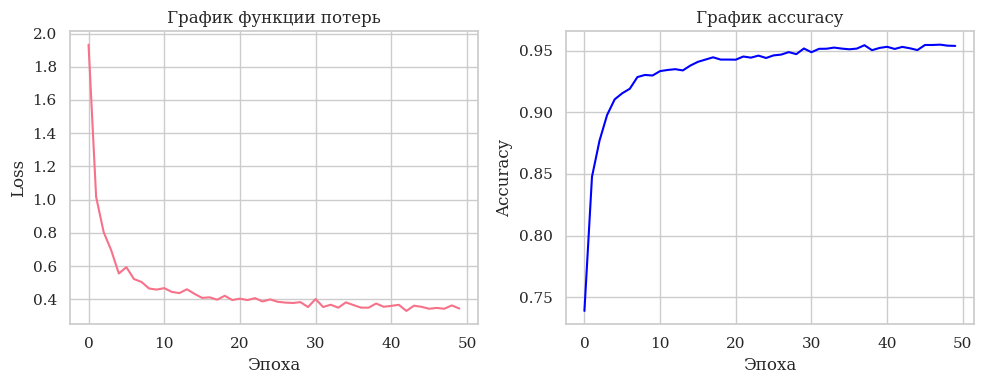

In [55]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss")
plt.title("График функции потерь")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies, label="Accuracy", color = 'blue')
plt.title("График accuracy")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()